Importamos librerías necesarias y obtenemos las etiquetas a partir de la ruta de cada carpeta

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

def proc_img(filepath):
    """ Se crea un DataFrame con el path del fichero y su correspondiente etiqueta
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Se concatenan las etiquetas y los paths
    df = pd.concat([filepath, labels], axis=1)

    # Se reinician los índices
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Se especifica cuál es el directorio de entrenamiento
train_dir = Path('./simpsons_dataset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

# Obtenemos el DataFrame con las etiquetas y los paths
df = proc_img(filepaths)

print(f'Número de imágenes: {df.shape[0]}\n')
print(f'Número de etiquetas únicas: {len(df.Label.unique())}\n')
print(f'Etiquetas: {df.Label.unique()}')

# Comprobamos que se ha hecho correctamente
df.head(5)

Número de imágenes: 41866

Número de etiquetas únicas: 42

Etiquetas: ['milhouse_van_houten' 'edna_krabappel' 'krusty_the_clown'
 'principal_skinner' 'moe_szyslak' 'abraham_grampa_simpson'
 'lenny_leonard' 'bart_simpson' 'homer_simpson' 'ned_flanders'
 'chief_wiggum' 'agnes_skinner' 'patty_bouvier' 'charles_montgomery_burns'
 'apu_nahasapeemapetilon' 'groundskeeper_willie' 'marge_simpson'
 'mayor_quimby' 'kent_brockman' 'ralph_wiggum' 'sideshow_bob'
 'lisa_simpson' 'comic_book_guy' 'waylon_smithers' 'martin_prince'
 'cletus_spuckler' 'professor_john_frink' 'maggie_simpson' 'otto_mann'
 'nelson_muntz' 'selma_bouvier' 'barney_gumble' 'carl_carlson'
 'rainier_wolfcastle' 'gil' 'troy_mcclure' 'fat_tony' 'miss_hoover'
 'sideshow_mel' 'snake_jailbird' 'disco_stu' 'lionel_hutz']


,Filepath,Label
0,simpsons_dataset\simpsons_dataset\milhouse_van...,milhouse_van_houten
1,simpsons_dataset\edna_krabappel\pic_0439.jpg,edna_krabappel
2,simpsons_dataset\krusty_the_clown\pic_0871.jpg,krusty_the_clown
3,simpsons_dataset\simpsons_dataset\principal_sk...,principal_skinner
4,simpsons_dataset\milhouse_van_houten\pic_1050.jpg,milhouse_van_houten


In [3]:
#Cargamos el conjunto de prueba
test_dir = Path('./kaggle_simpson_testset/')
filepaths_test = list(test_dir.glob(r'**/*.jpg'))
df_test= proc_img(filepaths_test)
df_test.head(5)

,Filepath,Label
0,kaggle_simpson_testset\lisa_simpson\lisa_simps...,lisa_simpson
1,kaggle_simpson_testset\mayor_quimby\mayor_quim...,mayor_quimby
2,kaggle_simpson_testset\kent_brockman\kent_broc...,kent_brockman
3,kaggle_simpson_testset\abraham_grampa_simpson\...,abraham_grampa_simpson
4,kaggle_simpson_testset\lenny_leonard\lenny_leo...,lenny_leonard


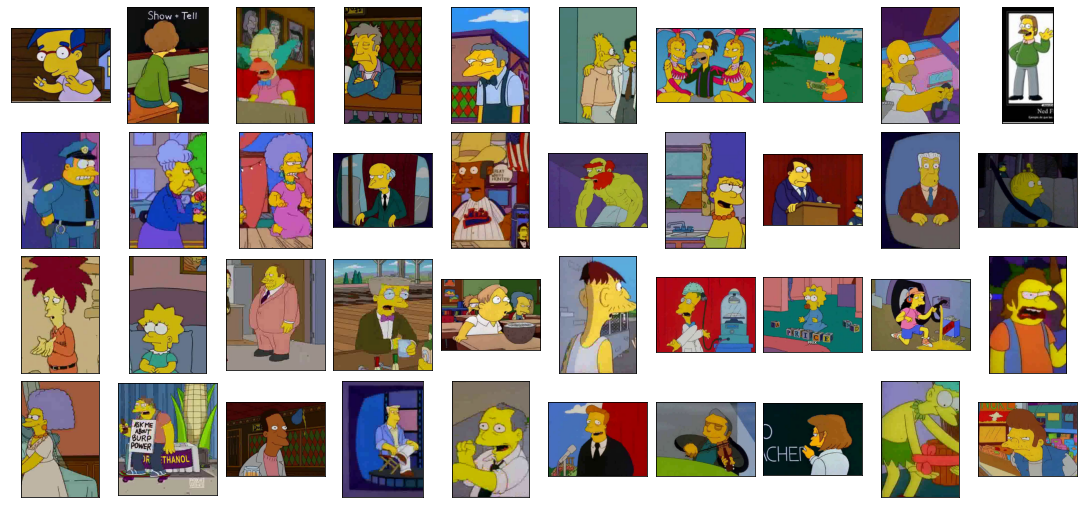

In [4]:
#Se eliminan las etiquetas duplicadas
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Se muestra una imagen de todos los personajes
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
plt.tight_layout(pad=0.5)
plt.show()

In [23]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [24]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 33493 validated image filenames belonging to 42 classes.
Found 8373 validated image filenames belonging to 42 classes.
Found 990 validated image filenames belonging to 20 classes.


In [25]:
#Cargamos los modelos pre-entrenados
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0

modelo_vgg16 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_inceptionv3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_resnet50 = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_efficientnetb0 = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')

modelo_vgg16.trainable = False
modelo_inceptionv3.trainable = False
modelo_resnet50.trainable = False
modelo_efficientnetb0.trainable = False

In [26]:
inputs = modelo_resnet50.input

x = tf.keras.layers.Dense(128, activation='relu')(modelo_resnet50.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_images, validation_data=val_images, epochs=20, batch_size=50, callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
])
model.summary()

Epoch 1/20
1047/1047 [==============================] - 2561s 2s/step - loss: 1.3566 - accuracy: 0.6416 - val_loss: 0.8546 - val_accuracy: 0.7662
Epoch 2/20
1047/1047 [==============================] - 2552s 2s/step - loss: 0.6591 - accuracy: 0.8184 - val_loss: 0.6184 - val_accuracy: 0.8310
Epoch 3/20
1047/1047 [==============================] - 2560s 2s/step - loss: 0.4438 - accuracy: 0.8731 - val_loss: 0.5891 - val_accuracy: 0.8377
Epoch 4/20
1047/1047 [==============================] - 2559s 2s/step - loss: 0.3251 - accuracy: 0.9054 - val_loss: 0.5961 - val_accuracy: 0.8371
Epoch 5/20
  22/1047 [..............................] - ETA: 33:42 - loss: 0.2135 - accuracy: 0.9332

KeyboardInterrupt: 